In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window, avg, count
from pyspark.ml import Pipeline

In [3]:
# Initialize Spark session
spark = SparkSession.builder.appName("Distributed Data Preprocessing and ML Modeling") .config("spark.some.config.option", "some-value") .getOrCreate()

In [4]:
# Load dataset
file_path = "/content/Traffic_Crashes_-_Crashes.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Inspect schema and data
data.printSchema()
data.show(5)


root
 |-- CRASH_RECORD_ID: string (nullable = true)
 |-- CRASH_DATE_EST_I: string (nullable = true)
 |-- CRASH_DATE: string (nullable = true)
 |-- POSTED_SPEED_LIMIT: integer (nullable = true)
 |-- TRAFFIC_CONTROL_DEVICE: string (nullable = true)
 |-- DEVICE_CONDITION: string (nullable = true)
 |-- WEATHER_CONDITION: string (nullable = true)
 |-- LIGHTING_CONDITION: string (nullable = true)
 |-- FIRST_CRASH_TYPE: string (nullable = true)
 |-- TRAFFICWAY_TYPE: string (nullable = true)
 |-- LANE_CNT: integer (nullable = true)
 |-- ALIGNMENT: string (nullable = true)
 |-- ROADWAY_SURFACE_COND: string (nullable = true)
 |-- ROAD_DEFECT: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- INTERSECTION_RELATED_I: string (nullable = true)
 |-- NOT_RIGHT_OF_WAY_I: string (nullable = true)
 |-- HIT_AND_RUN_I: string (nullable = true)
 |-- DAMAGE: string (nullable = true)
 |-- DATE_POLICE_NOTIFIED: string (nullable = true)
 |-- PRIM_

In [6]:
num_rows = data.count()
num_cols = len(data.columns)
print(f"Shape of the DataFrame: ({num_rows},{num_cols})")

Shape of the DataFrame: (876966,48)


In [7]:
df=data

# **Distributed Data Cleaning/Processing**

**Remove duplicate rows**

In [8]:
# Remove duplicate rows
df_no_duplicates = df.dropDuplicates()

**Handle Missing Values by Column Type**

In [9]:
from pyspark.sql.functions import mean, col, count, when, lit

# Step 1: Handle numeric columns
numeric_cols = [col_name for col_name, dtype in df_no_duplicates.dtypes if dtype in ('int', 'double')]

# Calculate the mean for numeric columns and fill nulls
for col_name in numeric_cols:
    mean_value = df_no_duplicates.select(mean(col(col_name)).alias('mean')).collect()[0]['mean']
    df_no_duplicates = df_no_duplicates.withColumn(col_name,when(col(col_name).isNull(), lit(mean_value)).otherwise(col(col_name)))

# Step 2: Handle categorical columns
categorical_cols = [col_name for col_name, dtype in df_no_duplicates.dtypes if dtype == 'string']

# Fill nulls with the mode (most frequent value) for categorical columns
for col_name in categorical_cols:
    mode_row = (df_no_duplicates.groupBy(col_name).count().orderBy(col("count").desc()).first())
    if mode_row:
        mode_value = mode_row[col_name]
        df_no_duplicates = df_no_duplicates.withColumn(col_name,when(col(col_name).isNull(), lit(mode_value)).otherwise(col(col_name)))

# Step 3: Checking any NULL values are present
df_no_duplicates.select([count(when(col(c).isNull(), c)).alias(c) for c in df_no_duplicates.columns]).show()


+---------------+----------------+----------+------------------+----------------------+----------------+-----------------+------------------+----------------+---------------+--------+---------+--------------------+-----------+-----------+----------+----------------------+------------------+-------------+------+--------------------+-----------------------+----------------------+---------+----------------+-----------+------------------+--------------+------------------+---------+-----------+--------------+-----------------+---------+------------------+--------------+--------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+--------+---------+--------+
|CRASH_RECORD_ID|CRASH_DATE_EST_I|CRASH_DATE|POSTED_SPEED_LIMIT|TRAFFIC_CONTROL_DEVICE|DEVICE_CONDITION|WEATHER_CONDITION|LIGHTING_CONDITION|FIRST_CRASH_TYPE|TRAFFICWAY_TYPE|LANE_CNT|ALIGNMENT|ROADWAY_SURFACE_COND|ROAD_DEF

In [10]:
df_no_duplicates.show()

+--------------------+----------------+--------------------+------------------+----------------------+--------------------+-----------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+-----------+--------------------+--------------------+----------------------+------------------+-------------+-------------+--------------------+-----------------------+----------------------+---------+----------------+-----------------+------------------+--------------+------------------+---------+-----------+--------------+-----------------+---------+--------------------+-------------------+--------------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+------------------+------------------+--------------------+
|     CRASH_RECORD_ID|CRASH_DATE_EST_I|          CRASH_DATE|POSTED_SPEED_LIMIT|TRAFFIC_CONTROL_DE

In [11]:
from pyspark.sql.functions import col, when, count

def replaceing_unknown_values_with_mode(df):
    for column in df.columns:
        # Calculate the most frequent value (mode) for the current column, excluding "UNKNOWN"
        mode_value = (
            df.filter(col(column) != "UNKNOWN")  # Exclude "UNKNOWN" from the calculation
            .groupBy(column).count().orderBy(col("count").desc()).first())

        if mode_value:
            mode_value = mode_value[0]  # Extract the most frequent value
            # Replace "UNKNOWN" with the most frequent value
            df = df.withColumn(column,when(col(column) == "UNKNOWN", mode_value).otherwise(col(column)))
    return df

df_updated = replaceing_unknown_values_with_mode(df_no_duplicates)
df_updated.show()


+--------------------+----------------+--------------------+------------------+----------------------+--------------------+-----------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+-----------+--------------------+--------------------+----------------------+------------------+-------------+-------------+--------------------+-----------------------+----------------------+---------+----------------+-----------------+------------------+--------------+------------------+---------+-----------+--------------+-----------------+---------+--------------------+-------------------+--------------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+------------------+------------------+--------------------+
|     CRASH_RECORD_ID|CRASH_DATE_EST_I|          CRASH_DATE|POSTED_SPEED_LIMIT|TRAFFIC_CONTROL_DE

In [12]:
from pyspark.sql.functions import when, col

# Replace values in the ROAD_DEFECT column
df_updated = df_updated.withColumn(
    "ROAD_DEFECT",
    when(col("ROAD_DEFECT") == "NO DEFECTS", "NO DEFECTS").otherwise("DEFECTS")
)


In [13]:
df_updated.show()

+--------------------+----------------+--------------------+------------------+----------------------+--------------------+-----------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+-----------+--------------------+--------------------+----------------------+------------------+-------------+-------------+--------------------+-----------------------+----------------------+---------+----------------+-----------------+------------------+--------------+------------------+---------+-----------+--------------+-----------------+---------+--------------------+-------------------+--------------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+------------------+------------------+--------------------+
|     CRASH_RECORD_ID|CRASH_DATE_EST_I|          CRASH_DATE|POSTED_SPEED_LIMIT|TRAFFIC_CONTROL_DE

In [14]:
a=df_updated

In [17]:
df_updated=a;

**Encode Categorical Columns**

In [19]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession

# Initialize Spark sess

# List of categorical columns to encode
categorical_columns = [
    "TRAFFIC_CONTROL_DEVICE",
    "DEVICE_CONDITION",
    "WEATHER_CONDITION",
    "LIGHTING_CONDITION",
    "FIRST_CRASH_TYPE",
    "TRAFFICWAY_TYPE",
    "ROADWAY_SURFACE_COND",
    "ROAD_DEFECT",
    "CRASH_TYPE",
    "DAMAGE"
]

# Create a dictionary to store the encoders for each column
indexers = {}

# Loop through the categorical columns and apply StringIndexer
for col_name in categorical_columns:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_encoded", handleInvalid="keep")
    indexers[col_name] = indexer
    df_updated = indexer.fit(df_updated).transform(df_updated)




In [20]:
from pyspark.sql.functions import when

# Modify DAMAGE_encoded column
df_updated = df_updated.withColumn(
    "DAMAGE_encoded",
    when(df_updated["DAMAGE_encoded"].isin(0, 1), 0).otherwise(1)
)

In [21]:
df_updated.show()

+--------------------+----------------+--------------------+------------------+----------------------+--------------------+-----------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+-----------+--------------------+--------------------+----------------------+------------------+-------------+-------------+--------------------+-----------------------+----------------------+---------+----------------+-----------------+------------------+--------------+------------------+---------+-----------+--------------+-----------------+---------+--------------------+-------------------+--------------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+------------------+------------------+--------------------+------------------------------+------------------------+-------------------------+----------------

In [22]:
output_file = "df_updated"  # Replace with your desired file path
df_updated.coalesce(1).write.csv(output_file, header=True, mode="overwrite")


**Removing Unwanted Columns**

In [23]:
columns_to_remove = ['CRASH_RECORD_ID', 'CRASH_DATE_EST_I','TRAFFIC_CONTROL_DEVICE','ALIGNMENT','REPORT_TYPE','INTERSECTION_RELATED_I','NOT_RIGHT_OF_WAY_I','HIT_AND_RUN_I','DATE_POLICE_NOTIFIED','PRIM_CONTRIBUTORY_CAUSE','SEC_CONTRIBUTORY_CAUSE','STREET_DIRECTION','REPORT_TYPE',
                     'BEAT_OF_OCCURRENCE','PHOTOS_TAKEN_I','STATEMENTS_TAKEN_I','DOORING_I','WORK_ZONE_I','WORK_ZONE_TYPE','WORKERS_PRESENT_I','MOST_SEVERE_INJURY','LOCATION','DEVICE_CONDITION','WEATHER_CONDITION' ,'LIGHTING_CONDITION' ,'FIRST_CRASH_TYPE','TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','ROAD_DEFECT','CRASH_TYPE','LATITUDE','LONGITUDE','STREET_NO','STREET_NAME',
                     'CRASH_DATE','DAMAGE']

# Drop the selected columns
df_updated = df_updated.drop(*columns_to_remove)
df_updated.show()

+------------------+------------------+---------+-------------------+--------------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+------------------------------+------------------------+-------------------------+--------------------------+------------------------+-----------------------+----------------------------+-------------------+------------------+--------------+
|POSTED_SPEED_LIMIT|          LANE_CNT|NUM_UNITS|     INJURIES_TOTAL|      INJURIES_FATAL|INJURIES_INCAPACITATING|INJURIES_NON_INCAPACITATING|INJURIES_REPORTED_NOT_EVIDENT|INJURIES_NO_INDICATION|INJURIES_UNKNOWN|CRASH_HOUR|CRASH_DAY_OF_WEEK|CRASH_MONTH|TRAFFIC_CONTROL_DEVICE_encoded|DEVICE_CONDITION_encoded|WEATHER_CONDITION_encoded|LIGHTING_CONDITION_encoded|FIRST_CRASH_TYPE_encoded|TRAFFICWAY_TYPE_encoded|ROADWAY_SURFACE_COND_encoded|ROAD_DEFECT_encoded|CRASH_TYPE_encoded|DAMAGE_encoded|
+---------

**Outlier Detection and Removal**

In [24]:
numeric_cols={'POSTED_SPEED_LIMIT','TRAFFIC_CONTROL_DEVICE_encoded','WEATHER_CONDITION_encoded','LIGHTING_CONDITION_encoded', 'FIRST_CRASH_TYPE_encoded','LANE_CNT','ROADWAY_SURFACE_COND_encoded','CRASH_TYPE_encoded','NUM_UNITS','INJURIES_TOTAL','INJURIES_FATAL','INJURIES_INCAPACITATING','INJURIES_NON_INCAPACITATING','INJURIES_REPORTED_NOT_EVIDENT','INJURIES_NO_INDICATION','INJURIES_UNKNOWN','ROAD_DEFECT_encoded','DEVICE_CONDITION_encoded'}

def remove_outliers(df, col_name):
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))

for col_name in numeric_cols:
    df_cleaned = remove_outliers(df_updated, col_name)


In [25]:
num_rows = df_cleaned.count()
num_cols = len(df_cleaned.columns)
print({num_rows}, {num_cols})

{739533} {23}


In [26]:
df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()

+------------------+--------+---------+--------------+--------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+------------------------------+------------------------+-------------------------+--------------------------+------------------------+-----------------------+----------------------------+-------------------+------------------+--------------+
|POSTED_SPEED_LIMIT|LANE_CNT|NUM_UNITS|INJURIES_TOTAL|INJURIES_FATAL|INJURIES_INCAPACITATING|INJURIES_NON_INCAPACITATING|INJURIES_REPORTED_NOT_EVIDENT|INJURIES_NO_INDICATION|INJURIES_UNKNOWN|CRASH_HOUR|CRASH_DAY_OF_WEEK|CRASH_MONTH|TRAFFIC_CONTROL_DEVICE_encoded|DEVICE_CONDITION_encoded|WEATHER_CONDITION_encoded|LIGHTING_CONDITION_encoded|FIRST_CRASH_TYPE_encoded|TRAFFICWAY_TYPE_encoded|ROADWAY_SURFACE_COND_encoded|ROAD_DEFECT_encoded|CRASH_TYPE_encoded|DAMAGE_encoded|
+------------------+--------+---------+-------------

In [27]:
# Remove rows where LANE_CNT is NULL
df_cleaned = df_cleaned.na.drop(subset=["LANE_CNT"])

# Display the result to confirm
df_cleaned.groupBy("LANE_CNT").count().orderBy("count", ascending=False).show()


+------------------+------+
|          LANE_CNT| count|
+------------------+------+
|13.329757406439683|574791|
|               2.0| 75458|
|               4.0| 40493|
|               1.0| 27451|
|               3.0|  7183|
|               0.0|  6837|
|               6.0|  3710|
|               5.0|  1579|
|               8.0|  1494|
|               7.0|   148|
|              10.0|   123|
|              99.0|    99|
|               9.0|    55|
|              11.0|    24|
|              12.0|    20|
|              20.0|    14|
|              22.0|     9|
|              15.0|     6|
|              16.0|     6|
|              40.0|     4|
+------------------+------+
only showing top 20 rows



In [28]:
# Get the number of rows
num_rows = df_cleaned.count()

# Get the number of columns
num_cols = len(df_cleaned.columns)

# Print the shape
print(f"Shape of the DataFrame: ({num_rows}, {num_cols})")


Shape of the DataFrame: (739533, 23)


In [29]:
df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()

+------------------+--------+---------+--------------+--------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+------------------------------+------------------------+-------------------------+--------------------------+------------------------+-----------------------+----------------------------+-------------------+------------------+--------------+
|POSTED_SPEED_LIMIT|LANE_CNT|NUM_UNITS|INJURIES_TOTAL|INJURIES_FATAL|INJURIES_INCAPACITATING|INJURIES_NON_INCAPACITATING|INJURIES_REPORTED_NOT_EVIDENT|INJURIES_NO_INDICATION|INJURIES_UNKNOWN|CRASH_HOUR|CRASH_DAY_OF_WEEK|CRASH_MONTH|TRAFFIC_CONTROL_DEVICE_encoded|DEVICE_CONDITION_encoded|WEATHER_CONDITION_encoded|LIGHTING_CONDITION_encoded|FIRST_CRASH_TYPE_encoded|TRAFFICWAY_TYPE_encoded|ROADWAY_SURFACE_COND_encoded|ROAD_DEFECT_encoded|CRASH_TYPE_encoded|DAMAGE_encoded|
+------------------+--------+---------+-------------

In [30]:
output_file = "df_cleaned"  # Replace with your desired file path
df_cleaned.coalesce(1).write.csv(output_file, header=True, mode="overwrite")


In [31]:
df_cleaned.groupBy("INJURIES_TOTAL").count().orderBy("count", ascending=False).show()

+-------------------+------+
|     INJURIES_TOTAL| count|
+-------------------+------+
|                0.0|637042|
|                1.0| 75873|
|                2.0| 16919|
|                3.0|  5157|
|                4.0|  1862|
|0.19333626654933803|  1528|
|                5.0|   659|
|                6.0|   272|
|                7.0|   109|
|                8.0|    48|
|                9.0|    26|
|               10.0|    11|
|               11.0|     7|
|               15.0|     5|
|               12.0|     5|
|               21.0|     3|
|               13.0|     3|
|               16.0|     1|
|               17.0|     1|
|               14.0|     1|
+-------------------+------+
only showing top 20 rows



**Standardization of Numerical Columns**

In [33]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.sql.functions import col

# Define the numerical columns to scale
numerical_columns = [
    "POSTED_SPEED_LIMIT",
    "LANE_CNT",
    "NUM_UNITS",
    "INJURIES_TOTAL"
]

# Assemble numerical columns into a single feature vector
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
assembled_df = assembler.transform(df_cleaned)

# Apply StandardScaler for normalization
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

# Keep both 'features' and 'scaled_features' columns in df_cleaned, and drop only the original numerical columns
df_cleaned = scaled_df.drop(*numerical_columns)

# Show the result
df_cleaned.show(truncate=False)


+---------------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+------------------------------+------------------------+-------------------------+--------------------------+------------------------+-----------------------+----------------------------+-------------------+------------------+--------------+----------------------------------+------------------------------------------------------------------------------------+
|INJURIES_FATAL       |INJURIES_INCAPACITATING|INJURIES_NON_INCAPACITATING|INJURIES_REPORTED_NOT_EVIDENT|INJURIES_NO_INDICATION|INJURIES_UNKNOWN|CRASH_HOUR|CRASH_DAY_OF_WEEK|CRASH_MONTH|TRAFFIC_CONTROL_DEVICE_encoded|DEVICE_CONDITION_encoded|WEATHER_CONDITION_encoded|LIGHTING_CONDITION_encoded|FIRST_CRASH_TYPE_encoded|TRAFFICWAY_TYPE_encoded|ROADWAY_SURFACE_COND_encoded|ROAD_DEFECT_encoded|CRASH_TYPE_encoded|DAMAGE_encoded|features                 

In [34]:
df_cleaned.show()

+--------------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+------------------------------+------------------------+-------------------------+--------------------------+------------------------+-----------------------+----------------------------+-------------------+------------------+--------------+--------------------+--------------------+
|      INJURIES_FATAL|INJURIES_INCAPACITATING|INJURIES_NON_INCAPACITATING|INJURIES_REPORTED_NOT_EVIDENT|INJURIES_NO_INDICATION|INJURIES_UNKNOWN|CRASH_HOUR|CRASH_DAY_OF_WEEK|CRASH_MONTH|TRAFFIC_CONTROL_DEVICE_encoded|DEVICE_CONDITION_encoded|WEATHER_CONDITION_encoded|LIGHTING_CONDITION_encoded|FIRST_CRASH_TYPE_encoded|TRAFFICWAY_TYPE_encoded|ROADWAY_SURFACE_COND_encoded|ROAD_DEFECT_encoded|CRASH_TYPE_encoded|DAMAGE_encoded|            features|     scaled_features|
+--------------------+-----------------------+----------------

**Algorithms/Visualizations**

In [35]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

feature_columns = [col for col in df_cleaned.columns if col != "DAMAGE_encoded" and col != "features"]


In [36]:
feature_columns

['INJURIES_FATAL',
 'INJURIES_INCAPACITATING',
 'INJURIES_NON_INCAPACITATING',
 'INJURIES_REPORTED_NOT_EVIDENT',
 'INJURIES_NO_INDICATION',
 'INJURIES_UNKNOWN',
 'CRASH_HOUR',
 'CRASH_DAY_OF_WEEK',
 'CRASH_MONTH',
 'TRAFFIC_CONTROL_DEVICE_encoded',
 'DEVICE_CONDITION_encoded',
 'WEATHER_CONDITION_encoded',
 'LIGHTING_CONDITION_encoded',
 'FIRST_CRASH_TYPE_encoded',
 'TRAFFICWAY_TYPE_encoded',
 'ROADWAY_SURFACE_COND_encoded',
 'ROAD_DEFECT_encoded',
 'CRASH_TYPE_encoded',
 'scaled_features']

In [37]:
# Assemble the final features into a single vector column
final_assembler = VectorAssembler(inputCols=feature_columns, outputCol="fin_features")
df_data = final_assembler.transform(df_cleaned)

# Split the dataset into training and testing sets
train_data, test_data = df_data.randomSplit([0.8, 0.2], seed=21)

In [38]:
train_data.select("fin_features")

DataFrame[fin_features: vector]

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

**Random Forest**

F1 Score: 0.833669197716605
Precision: 0.7865048053386289
Recall: 0.8868510615309816
Accuracy: 0.8868510615309816


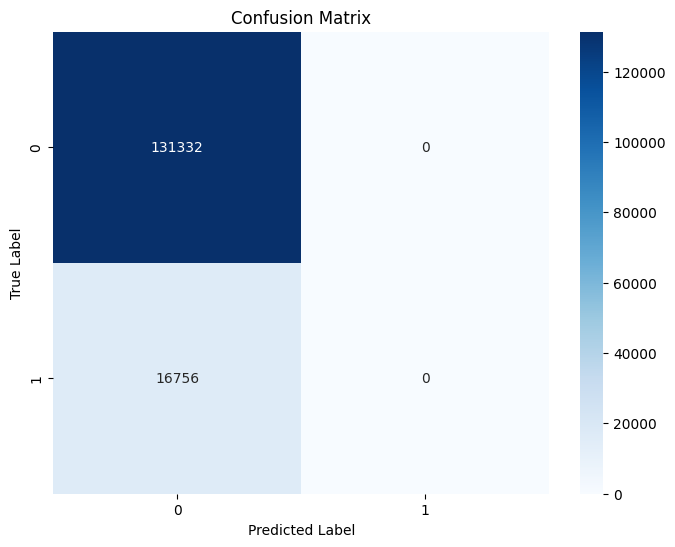

In [40]:
import time
from pyspark.ml.classification import RandomForestClassifier


start_time = time.time()
rf = RandomForestClassifier(labelCol="DAMAGE_encoded", featuresCol="fin_features")

# Train the model on the training set
model = rf.fit(train_data)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time for SVM: {training_time} seconds")

# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate metrics
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="weightedRecall")
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="accuracy")

f1_score = evaluator_f1.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
accuracy = evaluator_accuracy.evaluate(predictions)

print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

# Convert predictions to Pandas for confusion matrix
predictions_pd = predictions.select("DAMAGE_encoded", "prediction").toPandas()

# Get unique labels
labels = sorted(predictions_pd["DAMAGE_encoded"].unique())

# Create confusion matrix
cm = confusion_matrix(predictions_pd["DAMAGE_encoded"], predictions_pd["prediction"], labels=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()


**Logistic Regression**

Accuracy: 0.8867902868564638
F1 Score: 0.8336389186784564
Precision: 0.7864987064569121
Recall: 0.8867902868564638


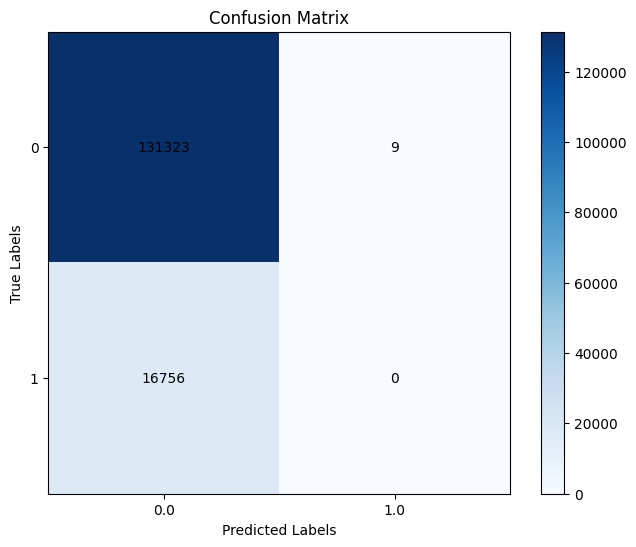

In [41]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col
import time

start_time = time.time()
# Define Logistic Regression
lr = LogisticRegression(featuresCol="fin_features", labelCol="DAMAGE_encoded")

# Fit the model
lr_model = lr.fit(train_data)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time for SVM: {training_time} seconds")

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Evaluate F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)

# Evaluate Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)

# Evaluate Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)

# Print Metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Create Confusion Matrix
confusion_matrix = predictions.groupBy("DAMAGE_encoded", "prediction").count().toPandas()

# Pivot Confusion Matrix for Plotting
pivot_matrix = confusion_matrix.pivot(index="DAMAGE_encoded", columns="prediction", values="count").fillna(0)

# Convert to NumPy Array for Plotting
confusion_array = pivot_matrix.to_numpy()

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(confusion_array, cmap="Blues")

# Add labels
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.set_xticks(np.arange(confusion_array.shape[1]))
ax.set_yticks(np.arange(confusion_array.shape[0]))
ax.set_xticklabels(pivot_matrix.columns)
ax.set_yticklabels(pivot_matrix.index)

# Display counts on the matrix
for i in range(confusion_array.shape[0]):
    for j in range(confusion_array.shape[1]):
        text = ax.text(j, i, int(confusion_array[i, j]), ha="center", va="center", color="black")

plt.colorbar(im)
plt.show()


**Decision Tree**

Accuracy: 0.8904502728107612
F1 Score: 0.8548148835359268
Precision: 0.8619016672333109
Recall: 0.8904502728107612


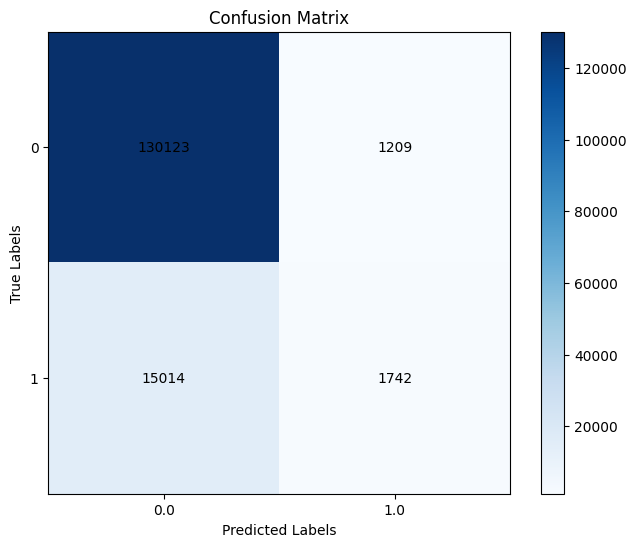

In [42]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col
import time

start_time = time.time()
# Define Decision Tree
dt = DecisionTreeClassifier(featuresCol="fin_features", labelCol="DAMAGE_encoded")

# Train the model
dt_model = dt.fit(train_data)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time for SVM: {training_time} seconds")

# Make predictions
dt_predictions = dt_model.transform(test_data)

# Evaluate Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(dt_predictions)

# Evaluate F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(dt_predictions)

# Evaluate Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(dt_predictions)

# Evaluate Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(dt_predictions)

# Print Metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Create Confusion Matrix
confusion_matrix = dt_predictions.groupBy("DAMAGE_encoded", "prediction").count().toPandas()

# Pivot Confusion Matrix for Plotting
pivot_matrix = confusion_matrix.pivot(index="DAMAGE_encoded", columns="prediction", values="count").fillna(0)

# Convert to NumPy Array for Plotting
confusion_array = pivot_matrix.to_numpy()

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(confusion_array, cmap="Blues")

# Add labels
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.set_xticks(np.arange(confusion_array.shape[1]))
ax.set_yticks(np.arange(confusion_array.shape[0]))
ax.set_xticklabels(pivot_matrix.columns)
ax.set_yticklabels(pivot_matrix.index)

# Display counts on the matrix
for i in range(confusion_array.shape[0]):
    for j in range(confusion_array.shape[1]):
        text = ax.text(j, i, int(confusion_array[i, j]), ha="center", va="center", color="black")

plt.colorbar(im)
plt.show()


In [43]:
a=df_cleaned.drop

In [44]:
d=df_cleaned.drop('features','scaled_features')

**Naive Bayes**

['INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'TRAFFIC_CONTROL_DEVICE_encoded', 'DEVICE_CONDITION_encoded', 'WEATHER_CONDITION_encoded', 'LIGHTING_CONDITION_encoded', 'FIRST_CRASH_TYPE_encoded', 'TRAFFICWAY_TYPE_encoded', 'ROADWAY_SURFACE_COND_encoded', 'ROAD_DEFECT_encoded', 'CRASH_TYPE_encoded', 'DAMAGE_encoded', 'fin_features']
['INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'TRAFFIC_CONTROL_DEVICE_encoded', 'DEVICE_CONDITION_encoded', 'WEATHER_CONDITION_encoded', 'LIGHTING_CONDITION_encoded', 'FIRST_CRASH_TYPE_encoded', 'TRAFFICWAY_TYPE_encoded', 'ROADWAY_SURFACE_COND_encoded', 'ROAD_DEFECT_encoded', 'CRASH_TYPE_encoded', 'DAMAGE_encoded', 'fin_features']
Accuracy: 0.88

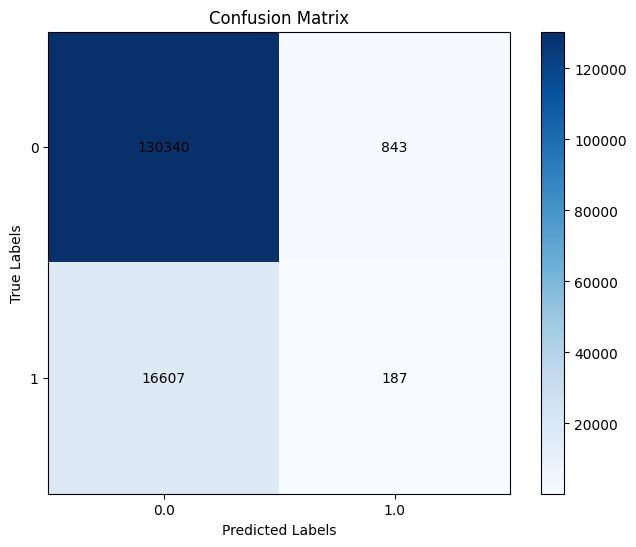

In [45]:
from pyspark.ml.classification import NaiveBayes
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np
import time

# Define the feature columns for the vector assembler
feature_columns = [col for col in d.columns if col != "DAMAGE_encoded" and col != "features"]

# Assemble the final features into a single vector column
final_assembler = VectorAssembler(inputCols=feature_columns, outputCol="fin_features")
df_data = final_assembler.transform(d)
print(df_data.columns)

# Split the dataset into training and testing sets
training_data, testing_data = df_data.randomSplit([0.8, 0.2], seed=42)
print(training_data.columns)

start_time = time.time()
# Define Naive Bayes
nb = NaiveBayes(featuresCol="fin_features", labelCol="DAMAGE_encoded")

# Train the model
nb_model = nb.fit(training_data)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time for SVM: {training_time} seconds")

# Make predictions
nb_predictions = nb_model.transform(testing_data)

# Evaluate Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(nb_predictions)

# Evaluate F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(nb_predictions)

# Evaluate Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(nb_predictions)

# Evaluate Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(nb_predictions)

# Print Metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Create Confusion Matrix
confusion_matrix = nb_predictions.groupBy("DAMAGE_encoded", "prediction").count().toPandas()

# Pivot Confusion Matrix for Plotting
pivot_matrix = confusion_matrix.pivot(index="DAMAGE_encoded", columns="prediction", values="count").fillna(0)

# Convert to NumPy Array for Plotting
confusion_array = pivot_matrix.to_numpy()

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(confusion_array, cmap="Blues")

# Add labels
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.set_xticks(np.arange(confusion_array.shape[1]))
ax.set_yticks(np.arange(confusion_array.shape[0]))
ax.set_xticklabels(pivot_matrix.columns)
ax.set_yticklabels(pivot_matrix.index)

# Display counts on the matrix
for i in range(confusion_array.shape[0]):
    for j in range(confusion_array.shape[1]):
        text = ax.text(j, i, int(confusion_array[i, j]), ha="center", va="center", color="black")

plt.colorbar(im)
plt.show()


**Gradient Boosted Trees (XGBClassifier)**

Accuracy: 0.8906384100231792
F1 Score: 0.8553043195895673
Precision: 0.863146986374474
Recall: 0.8906384100231793


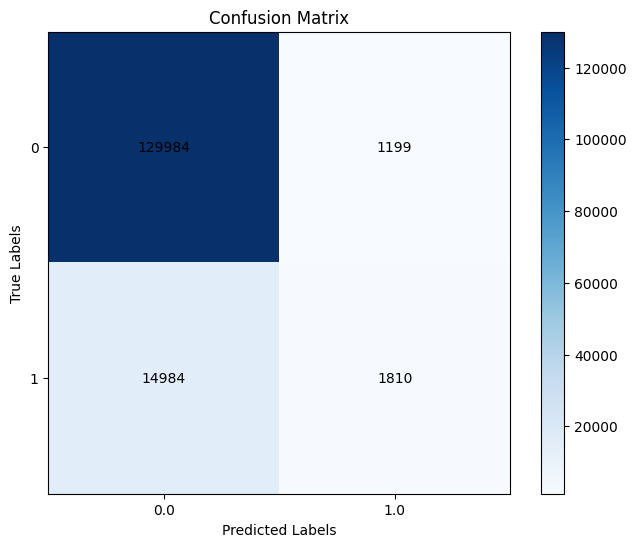

In [46]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import numpy as np
import time

# Define the feature columns for the vector assembler
feature_columns = [col for col in df_cleaned.columns if col != "DAMAGE_encoded" and col != "features"]

start_time = time.time()

# Define Gradient Boosted Trees
gbt = GBTClassifier(featuresCol="fin_features", labelCol="DAMAGE_encoded", maxIter=100)

# Train the model
gbt_model = gbt.fit(training_data)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time for SVM: {training_time} seconds")

# Make predictions
gbt_predictions = gbt_model.transform(testing_data)

# Evaluate Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(gbt_predictions)

# Evaluate F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(gbt_predictions)

# Evaluate Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(gbt_predictions)

# Evaluate Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(gbt_predictions)

# Print Metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Create Confusion Matrix
confusion_matrix = gbt_predictions.groupBy("DAMAGE_encoded", "prediction").count().toPandas()

# Pivot Confusion Matrix for Plotting
pivot_matrix = confusion_matrix.pivot(index="DAMAGE_encoded", columns="prediction", values="count").fillna(0)

# Convert to NumPy Array for Plotting
confusion_array = pivot_matrix.to_numpy()

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(confusion_array, cmap="Blues")

# Add labels
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.set_xticks(np.arange(confusion_array.shape[1]))
ax.set_yticks(np.arange(confusion_array.shape[0]))
ax.set_xticklabels(pivot_matrix.columns)
ax.set_yticklabels(pivot_matrix.index)

# Display counts on the matrix
for i in range(confusion_array.shape[0]):
    for j in range(confusion_array.shape[1]):
        text = ax.text(j, i, int(confusion_array[i, j]), ha="center", va="center", color="black")

plt.colorbar(im)
plt.show()


**Support Vector Machines (SVM)**

Training Time for SVM: 283.42291593551636 seconds
Accuracy: 0.8865093899727661
F1 Score: 0.8331778285198264
Precision: 0.7858988985098858
Recall: 0.8865093899727661


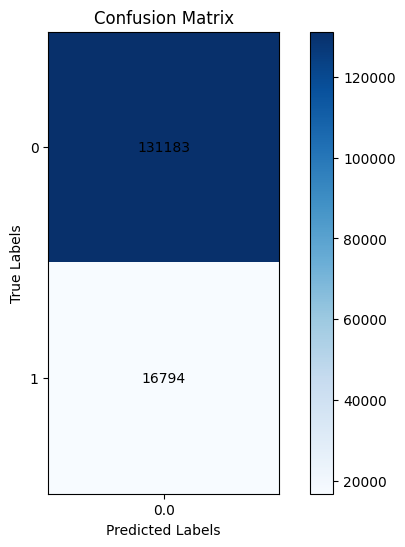

In [47]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import numpy as np
import time

# Define the feature columns for the vector assembler
feature_columns = [col for col in df_cleaned.columns if col != "DAMAGE_encoded" and col != "features"]


start_time = time.time()

# Define Linear Support Vector Classifier (SVM)
svm = LinearSVC(featuresCol="fin_features", labelCol="DAMAGE_encoded")

# Train the model
svm_model = svm.fit(training_data)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time for SVM: {training_time} seconds")

# Make predictions
svm_predictions = svm_model.transform(testing_data)

# Evaluate Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(svm_predictions)

# Evaluate F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(svm_predictions)

# Evaluate Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(svm_predictions)

# Evaluate Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="DAMAGE_encoded", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(svm_predictions)

# Print Metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Create Confusion Matrix
confusion_matrix = svm_predictions.groupBy("DAMAGE_encoded", "prediction").count().toPandas()

# Pivot Confusion Matrix for Plotting
pivot_matrix = confusion_matrix.pivot(index="DAMAGE_encoded", columns="prediction", values="count").fillna(0)

# Convert to NumPy Array for Plotting
confusion_array = pivot_matrix.to_numpy()

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(confusion_array, cmap="Blues")

# Add labels
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.set_xticks(np.arange(confusion_array.shape[1]))
ax.set_yticks(np.arange(confusion_array.shape[0]))
ax.set_xticklabels(pivot_matrix.columns)
ax.set_yticklabels(pivot_matrix.index)

# Display counts on the matrix
for i in range(confusion_array.shape[0]):
    for j in range(confusion_array.shape[1]):
        text = ax.text(j, i, int(confusion_array[i, j]), ha="center", va="center", color="black")

plt.colorbar(im)
plt.show()


In [49]:
# %%capture
!pip install pyngrok

from pyngrok import ngrok, conf
import getpass

print("https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()

ui_port = 4040
public_url = ngrok.connect(ui_port).public_url
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{ui_port}\"")

https://dashboard.ngrok.com/get-started/your-authtoken
··········


 * ngrok tunnel "https://3510-35-229-36-166.ngrok-free.app" -> "http://127.0.0.1:4040"
